# Getting Started with `FEEMS` & `FEEMSmix`

This notebook illustrates a minimal example of how to run `FEEMS` and `FEEMSmix` on a dataset of North American gray wolves published in [Schweizer _et al_ 2016](https://onlinelibrary.wiley.com/doi/full/10.1111/mec.13364?casa_token=idW0quVPOU0AAAAA%3Ao_ll85b8rDbnW3GtgVeeBUB4oDepm9hQW3Y445HI84LC5itXsiH9dGO-QYGPMsuz0b_7eNkRp8Mf6tlW).

## Imports

First we import the required packages and `FEEMS`:

In [11]:
# base
import numpy as np
# import pkg_resources -> deprecated
from importlib import resources
from sklearn.impute import SimpleImputer
from pandas_plink import read_plink
import statsmodels.api as sm

# viz
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature

# feems
from feems.utils import prepare_graph_inputs, cov_to_dist
from feems.objective import comp_mats
from feems.viz import draw_FEEMSmix_surface, plot_FEEMSmix_summary
from feems import SpatialGraph, Objective, Viz

# change matplotlib fonts
plt.rcParams["font.family"] = "Arial"
plt.rcParams["font.sans-serif"] = "Arial"

### The documentation for all `FEEMS`/`FEEMSmix` functions can be queried in a notebook environment by typing `?function`

In [9]:
# for example
?draw_FEEMSmix_surface

Signature:
draw_FEEMSmix_surface(
    v,
    ind_results,
    demes=None,
    draw_arrow=True,
    draw_c_surface=False,
    magnifier=1,
    dpi=300,
    figsize=(4, 10),
)
Docstring:
Wrapper function to plot the entire suite of fits from separately fitting each edge
Required:
    v (:obj:`feems.Viz`): Viz object created previously 
    ind_results (:obj:`dict`): output from sp_graph.sequential_fit(...)
    
Optional:
    demes (:obj:`int` or `list`): number or list of edge indices to plot (for any single index, use e.g., [980])
    draw_c_surface (:obj:`Bool`): whether to include a surface of the admixture proportions
    draw_arrow (:obj:`Bool`): whether to draw LREs as arrows
    magnifier (:obj:`float`): scaler on the size of the arrows 
    dpi (:obj:`int`): resolution of figure
    figsize (:obj:`tuple`): (width, height) of matplotlib plot 

Returns: 
    None        
File:      ~/src/feems/feems/viz.py
Type:      function

## Data

Note we have packaged this example dataset in the `FEEMS` package and use the `importlib.resources` package to find the path of those files:

_Note: We were previously using `pkg_resources`, but that package has been deprecated (see [https://setuptools.pypa.io/en/latest/pkg_resources.html](https://setuptools.pypa.io/en/latest/pkg_resources.html))_

In [13]:
data_path = str(resources.files('feems') / 'data')

Next we read the `plink` formatted genotype data and impute any missing SNPs with the mean at each SNP:

In [14]:
# read the genotype data and mean impute missing data
(bim, fam, G) = read_plink("{}/wolvesadmix".format(data_path))
imp = SimpleImputer(missing_values=np.nan, strategy="mean")
genotypes = imp.fit_transform((np.array(G)).T)

print("n_samples={}, n_snps={}".format(genotypes.shape[0], genotypes.shape[1]))

Mapping files: 100%|██████████| 3/3 [00:00<00:00, 20.98it/s]

n_samples=111, n_snps=17729


As we can see we have 111 samples and 17,729 SNPs. For preparing the graph inputs to run `FEEMS` you have two options:

* Prepare your own input files
* Use the `FEEMS` function `prepare_graph_inputs` which intersects a discrete global grid (DGG) with the sample range

We'll show off the latter option as it is easier to get started. 

You only require coordinates for each sampled individual. The outer polygon can either be supplied or chosen by `FEEMS` via the `buffer` flag. The DGG can also be chosen from some defaults or specified separately (see README.md).

In [15]:
%%time
# setup graph
coord = np.loadtxt("{}/wolvesadmix.coord".format(data_path))  # sample coordinates
outer = np.loadtxt("{}/wolvesadmix.outer".format(data_path))  # outer coordinates
grid_path = "{}/grid_100.shp".format(data_path)  # path to discrete global grid

# graph input files
outer, edges, grid, _ = prepare_graph_inputs(coord=coord, 
                                             ggrid=grid_path,
                                             translated=True, 
                                             buffer=0,
                                             outer=outer)

CPU times: user 4.89 s, sys: 42.6 ms, total: 4.93 s
Wall time: 4.96 s


Lets take a look at the initialized grid points with the outer boundary and the corresponding sample points (here is where you can make changes before proceeding any further, i.e., does the outer boundary encompass the sample locations in black or is the grid fine enough?): 

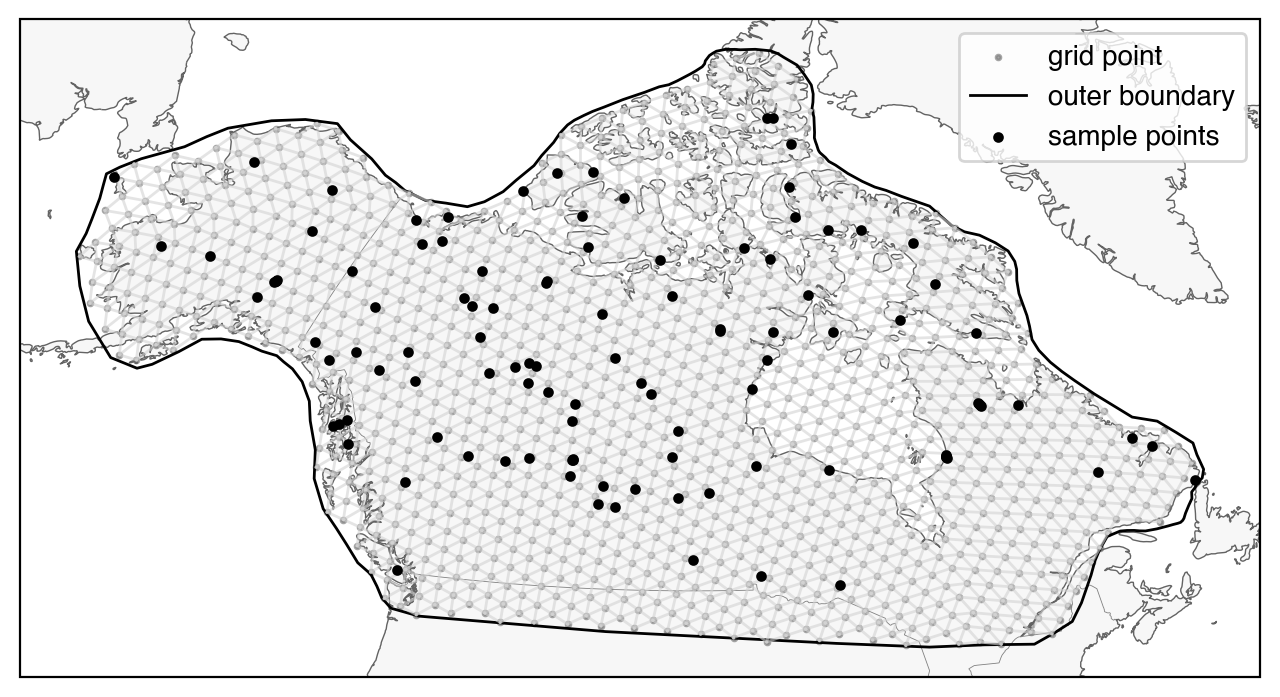

In [16]:
plt.figure(dpi=200, figsize=(8,6))
projection = ccrs.AzimuthalEquidistant(central_longitude=-100)
ax = plt.axes(projection=projection)

# add coastlines, borders, and land features
ax.add_feature(cfeature.COASTLINE, edgecolor='#636363', linewidth=0.5)
ax.add_feature(cfeature.BORDERS, edgecolor='gray', linewidth=0.3)
ax.add_feature(cfeature.LAND, facecolor='#f7f7f7')

# add grid points
ax.scatter(grid[:, 0], grid[:, 1], s=3, color='grey', alpha=0.7, transform=ccrs.PlateCarree(), label='grid point')

# add outer boundary
ax.plot(outer[:, 0], outer[:, 1], color='black', linewidth=1, transform=ccrs.PlateCarree(), label='outer boundary')

# add edges
for edge in edges:
    i, j = edge - 1
    ax.plot([grid[i, 0], grid[j, 0]], [grid[i, 1], grid[j, 1]], 
            color='lightgray', linewidth=1, alpha=0.6, transform=ccrs.PlateCarree())

# add sample points
ax.scatter(coord[:, 0], coord[:, 1], s=8, color='black', zorder=2,transform=ccrs.PlateCarree(), label='sample points')
plt.legend()

## Setup the `SpatialGraph` object

We then setup the `SpatialGraph` object which is the core workhorse of `FEEMS`. `SpatialGraph` specifies the graph, allele frequency data, and runs the optimizers to fit the edge weights of the graph:

In [17]:
%%time
sp_graph = SpatialGraph(genotypes, coord, grid, edges, scale_snps=True)

Initializing graph...
Computing graph attributes...
Assigning samples to nodes...done.
CPU times: user 42.8 s, sys: 645 ms, total: 43.4 s
Wall time: 43.5 s


This might take a few minutes to construct at first b/c it initializes a number of graph matrices that are slow to build. First, before any fitting we'll visualize the graph and samples. Lets setup the projection we'll be using for this dataset:

_(We choose `AzimuthalEquidistant` here as it provides better scaling for regions closer to the poles. A good rule of thumb to follow here is to visually inspect the relative size of edges across the grid and check to make sure it is roughly similar. With `EquidistantConic`, we notice that edges closer to the poles are much wider than their more southern counterparts.)_

In [18]:
projection = ccrs.AzimuthalEquidistant(central_longitude=-108.842926, central_latitude=66.037547)

Now lets make a map of the sample coordinates, graph and observed nodes:

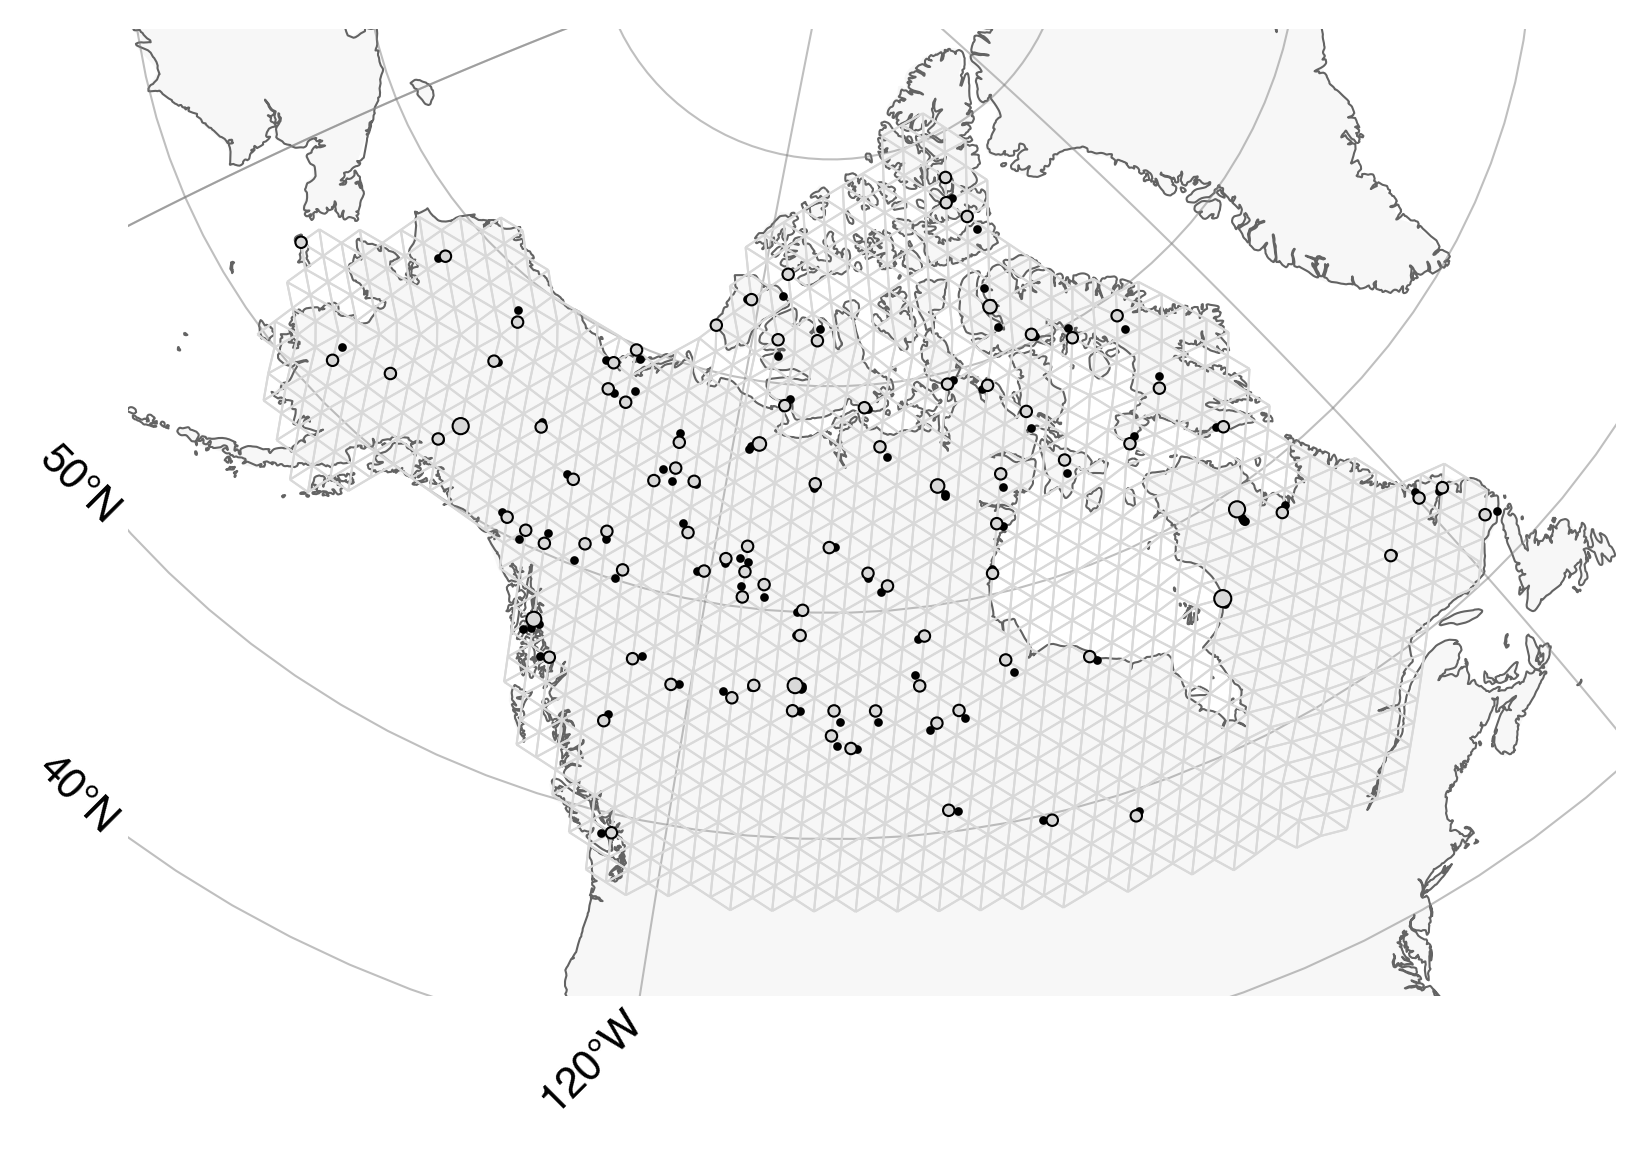

In [19]:
fig = plt.figure(dpi=300)
ax = fig.add_subplot(1, 1, 1, projection=projection)  
v = Viz(ax, sp_graph, projection=projection, edge_width=.5, 
        edge_alpha=1, edge_zorder=100, sample_pt_size=10, 
        obs_node_size=7.5, sample_pt_color="black", 
        cbar_font_size=10)
v.draw_map(longlat=True)
v.draw_samples()
v.draw_edges(use_weights=False)
v.draw_obs_nodes(use_ids=False)

The black points are the observed locations for each sample and the gray points show the nodes that samples were assigned to. The gray lines represent the graph that will be fitted.

_Optional_: The latitude and longitude gridlines can be customized using `v.draw_map()`.

## Fit `FEEMS` (node-specific variance, default in _v2.0_)

In the latest version of `FEEMS`, we include a mode in which we fit separate variances for each sampled node in the graph (as opposed to a single fixed variance, see _further-exploration.ipynb_). This increases the number of parameters to be fit by the model by the number of sampled demes, which is $94$ in this case.  

As a result, we also have a new parameter called `lamb_q` which is a penalty on the node-specific variances (larger the value, the more similar the variances across the grid will be and vice versa). You could think of this as a slider to adjust for how different you expect the heterozygosities to be across the habitat.

In [20]:
%%time
sp_graph.fit(lamb = 2.0, lamb_q = 10.0, optimize_q = 'n-dim')

CPU times: user 30.2 s, sys: 1.6 s, total: 31.8 s
Wall time: 9.71 s


On my computer, this fit took over $\sim 5\times$ longer than the default fixed node-specific variance fit (from _v1.0_). We've observed better quantitative fits with this version so we make this the default in _v2.0_. 

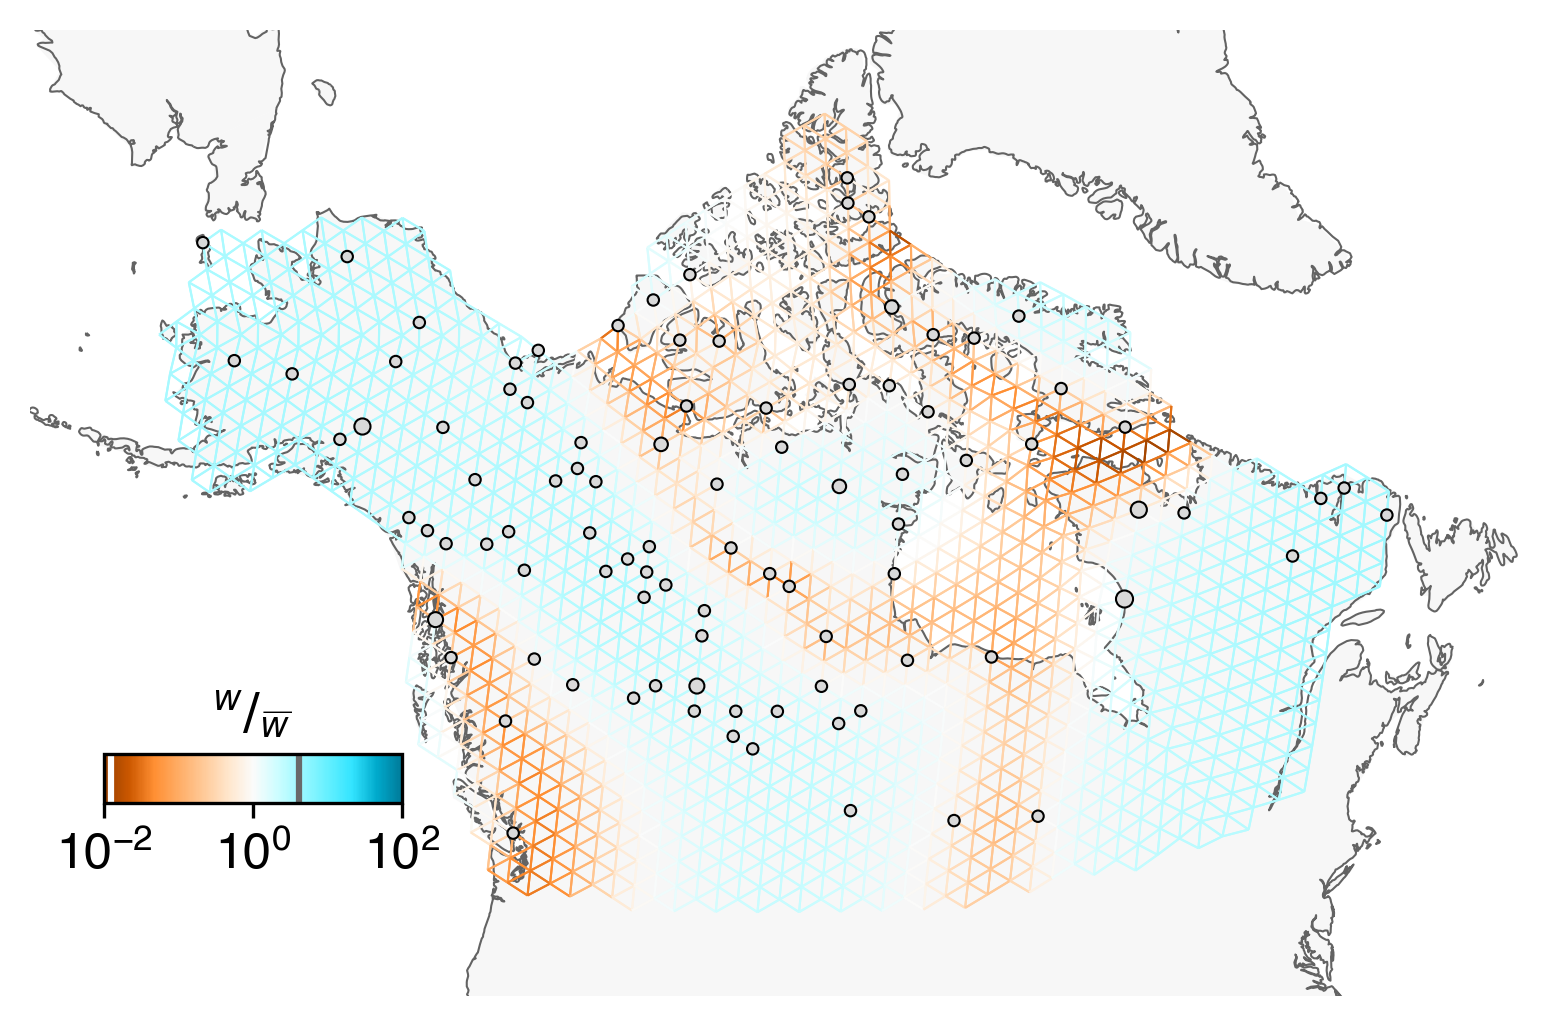

In [21]:
fig = plt.figure(dpi=300)
ax = fig.add_subplot(1, 1, 1, projection=projection)  
v = Viz(ax, sp_graph, projection=projection, edge_width=.5, 
        edge_alpha=1, edge_zorder=100, sample_pt_size=20, 
        obs_node_size=7.5, sample_pt_color="black", 
        cbar_font_size=10)
v.draw_map()
v.draw_edges(use_weights=True)
v.draw_obs_nodes(use_ids=False) 
v.draw_edge_colorbar()

We can also visualize the fit of the model to the observed pairwise genetic distances from the genotype matrix. This is a useful way of diagnosing the model fit. 

Text(0.5, 1.0, '$\\tt{FEEMS}$ fit with estimated node-specific variances')

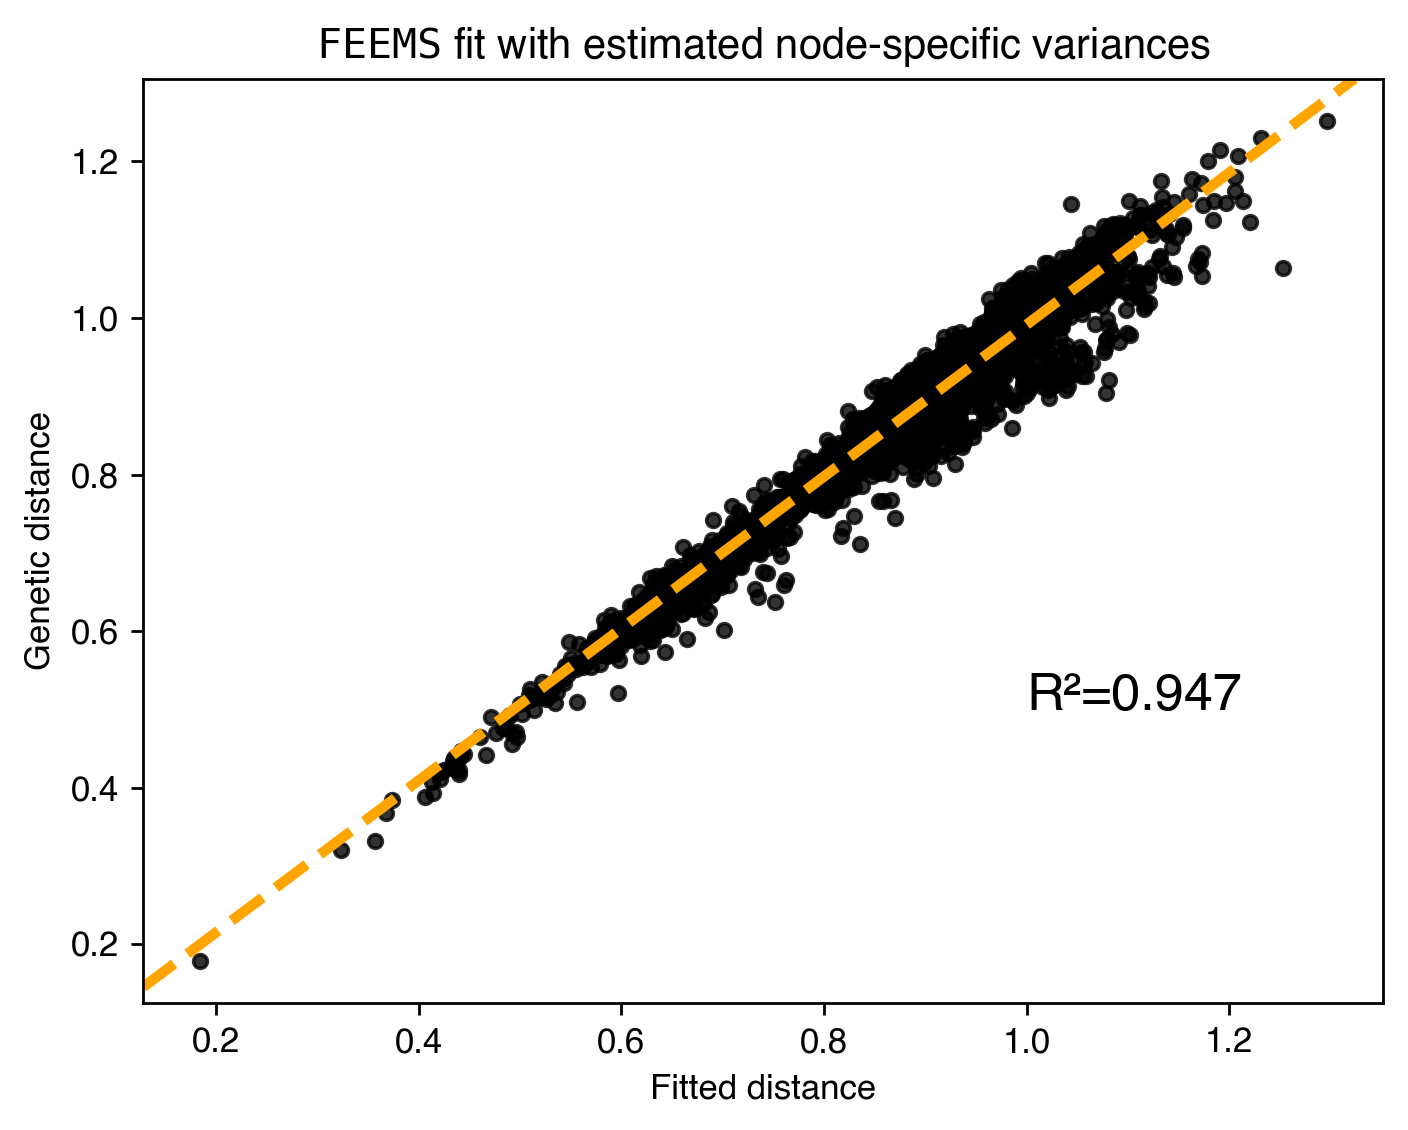

In [22]:
# creating an obj 
obj = Objective(sp_graph); obj.inv(); obj.grad(reg=False)
# computing distances matrice for fit (expected) vs empirical (observed) 
fit_cov, _, emp_cov = comp_mats(obj)
# subsetting matrices to arrays 
fit_dist = cov_to_dist(fit_cov)[np.tril_indices(sp_graph.n_observed_nodes, k=-1)]
emp_dist = cov_to_dist(emp_cov)[np.tril_indices(sp_graph.n_observed_nodes, k=-1)]

# fitting a linear model to the observed distances
X = sm.add_constant(fit_dist)
mod = sm.OLS(emp_dist, X)
res = mod.fit()
muhat, betahat = res.params

plt.figure(dpi=250)
plt.plot(fit_dist, emp_dist, 'o', color='k', alpha=0.8, markersize=4)
plt.axline((0.5,0.5*betahat+muhat), slope=betahat, color='orange', ls='--', lw=3)
plt.text(1, 0.5, "R²={:.3f}".format(res.rsquared), fontsize=15)
plt.xlabel('Fitted distance'); plt.ylabel('Genetic distance')
plt.title(r"$\tt{FEEMS}$ fit with estimated node-specific variances")

Great ... now we see our first `FEEMS` plot! We essentially provided these results interactively! For more interpretation of these figures and method please see the publication here: https://doi.org/10.7554/eLife.61927

# Fit `FEEMSmix` 

We will now go through the workflow of fitting long-range gene flow events over this baseline estimated migration surface found by `FEEMS`. This methodology is very similar to the idea of adding edges to an underlying topology in `TreeMix` (Pickrell & Pritchard 2012). 

Please refer to the preprint (https://doi.org/10.1101/2025.02.10.637386) for a more detailed explanation of the methods. 
There are three modes in which this can be run. There will be a fair bit of overlap in the results amongst the approaches, so we recommend users to choose what is best for their data:

1. detect outliers on a baseline fit -> model largest outlier on the baseline graph -> find outliers on this new graph (baseline + long-range edge or LRE) -> repeat for a user-specified $K$ LRE (recommended approach)
2. detect outliers on the baseline fit -> model each outlier _independently_ -> repeat until cycled through all outliers 
3. model long-range gene flow to any user-specified deme 

Outliers are chosen as the demes showing the largest negative residuals under the baseline fit. 

With all three modes, we employ a two-stage approach to finding the MLE location of the source and the admixture proportion. In the *first* stage, we separately fit an admixture proportion from `all` nodes (or some user-specified set of nodes) to a particular destination deme (assuming fixed weights and variances). In the *second* stage, we take the `top` (percent or number) nodes from the *first* stage (based on the log-likelihood) and refit the admixture proportions in a _joint_ manner with the weights and variances. This *second* stage is a costly procedure so we don't employ it on _all_ the nodes in the graph, however, we've found equivalent results with both schemes in the simulation (so we let users decide the value for `top`, default: $5\%$ or $0.05$).  

In this notebook, we only show the _recommended_ approach. Refer to _further-exploration.ipynb_ for ways to run the other two modes.

### Detecting outliers on baseline graph

We start by picking the top $1\%$ of pairs as putative outliers. We are not too concerned with a higher fraction as we've noticed that, typically, in the presence of false positives, the estimated admixture proportions tend to be small (see example at the very end of this notebook for deme _445_). 

In [23]:
# choose a specified level 
outliers_df = sp_graph.extract_outliers(fraction_of_pairs=0.01)

Using a top fraction of 0.01: 
  Putative recipient demes: [980 207 180 189 402 585 621 747 815]


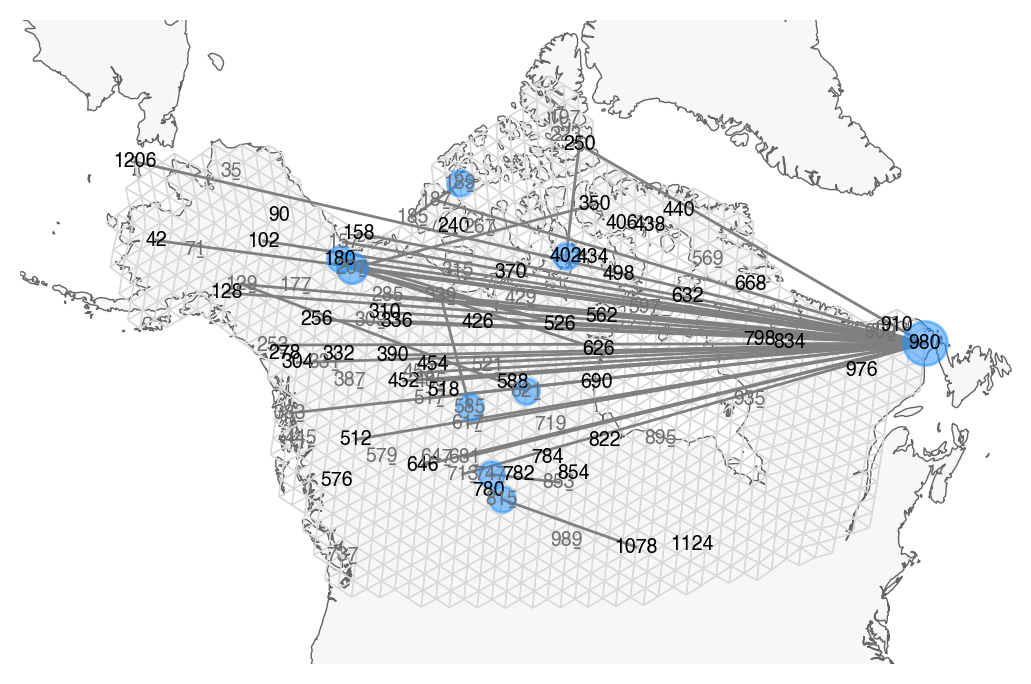

In [24]:
# visualizing the outlier demes on the map
fig = plt.figure(dpi=200)
ax = fig.add_subplot(1, 1, 1, projection=projection)  
v = Viz(ax, sp_graph, projection=projection, edge_width=.5, 
        edge_alpha=1, edge_zorder=100, sample_pt_size=20, 
        obs_node_size=7.5, sample_pt_color="black", 
        cbar_font_size=10)
v.draw_map(); v.draw_edges(use_weights=False)
# ~NEW~ function
v.draw_outliers(outliers_df)
# using deme IDs since all results will be represented with these numbers
v.draw_obs_nodes(use_ids=True)

## Option 1 (`sequential_fit`)

This is the recommended mode for fitting `FEEMSmix`. We recommend users start with $K=10$ LREs and go from there by observing summary fo fits under the model. Here, we only show $K=3$ and $top=0.005$ for illustrative purposes. 

Three important flags to highlight here:
1. *nedges*: number of total edges $K$ to fit in a sequential fashion 
2. *nedges_to_same_deme*: number of edges to add to the same destination deme (here, we default to $2$ as we've found potential overfitting in certain scenarios, but we leave it up to users to decide based on their application)
3. *top*: what is the top fraction or number of demes to choose when fitting the joint surface? (default: $0.01$, increasing this value will amount to longer runtimes but with a better quantification of the likelihood surface for a LRE)

*search_area* is a flag that determines how large the search space should be when fitting the joint surface (here, we search over the entire grid by choosing 'all') and *fraction_of_pairs* sets the fraction of top outlier pairs to include when picking the next LRE. 

In [25]:
%%time
seq_results = sp_graph.sequential_fit(
    outliers_df=outliers_df, 
    lamb=2.0, lamb_q=1.0, optimize_q='n-dim', 
    nedges=3, nedges_to_same_deme=2, top=0.005,
    search_area='all',
    fraction_of_pairs=0.01
)

Log-likelihood of initial fit: 7855.7

Deme ID and # of times it was implicated as an outlier:
980    31
207     5
815     1
621     1
747     1
Name: dest., dtype: int64

Fitting long-range edge to deme 980:
  Optimizing likelihood over 1045 demes in the graph...25%...50%...75%...done!
	Optimizing joint likelihood over 6/6 most likely demes in the graph...done!

  Log-likelihood after fitting deme 980: 8228.7
  Previous edge to deme 980 significantly increased the log-likelihood.
Current edge included in final fit.

Using a top fraction of 0.05: 
  Putative recipient demes: [ 180  207 1206  187  621  834  585  285  910  336  390  980  339  632
  815  157  690  895  976  747  719  713  935  129  597 1124  453  438
  402  370  350  332  331  189  668  526]
Deme ID and # of times it was implicated as an outlier:
180     45
207     37
1206    26
187     26
621     18
Name: dest., dtype: int64

Fitting long-range edge to deme 180:
  Optimizing likelihood over 1040 demes in the graph...25%.

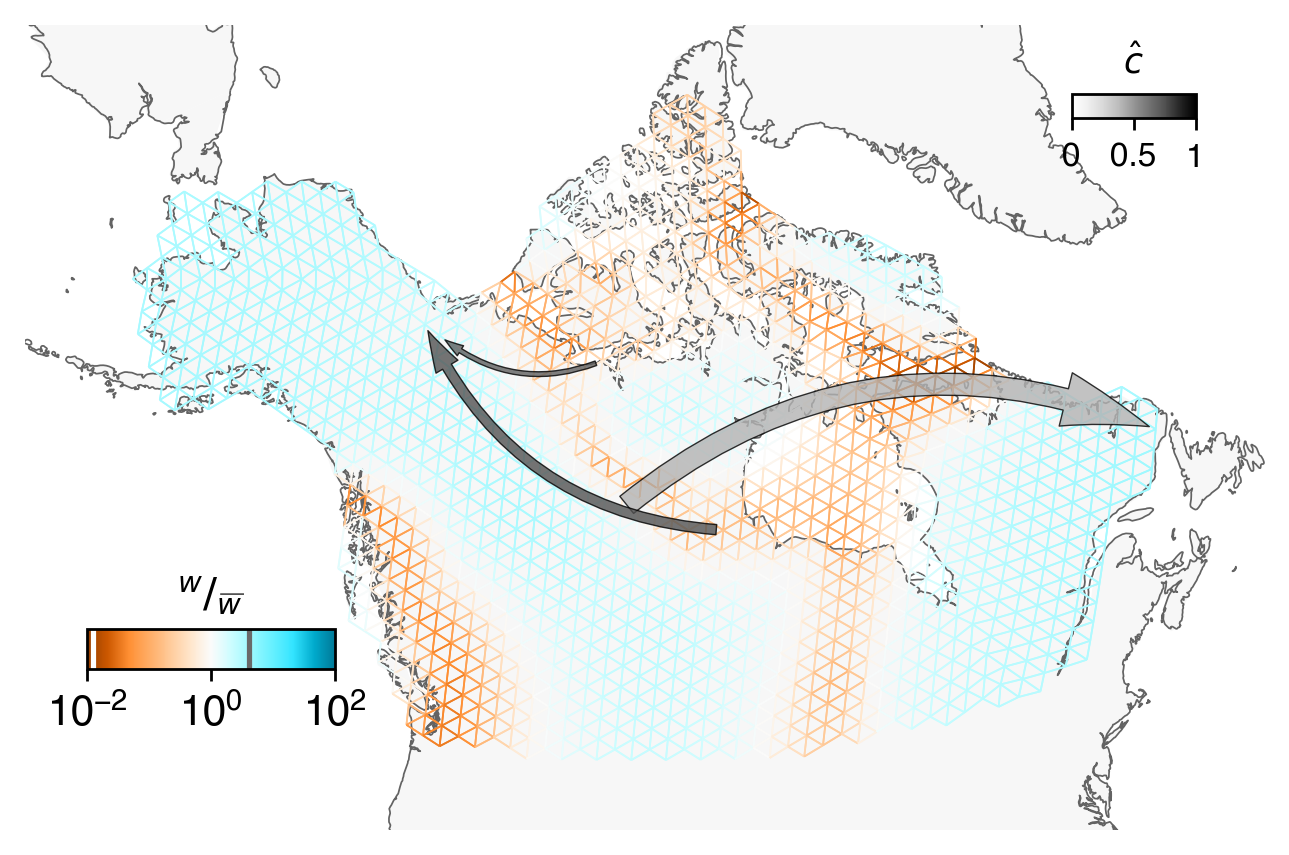

In [26]:
# visualizing the LREs as arrows
fig = plt.figure(dpi=250)
ax = fig.add_subplot(1, 1, 1, projection=projection)  
v = Viz(ax, sp_graph, projection=projection, edge_width=.5, 
        edge_alpha=1, edge_zorder=100, sample_pt_size=20, 
        obs_node_size=7.5, sample_pt_color="black", 
        cbar_font_size=10)
v.draw_map(); v.draw_edges(use_weights=True); v.draw_edge_colorbar()
v.draw_LREs(seq_results); v.draw_c_colorbar()

Here we show a summary of the fit object or surface using model $R^2$ with a diagnostic scatter plot between the pairs of observed and fitted distances. 

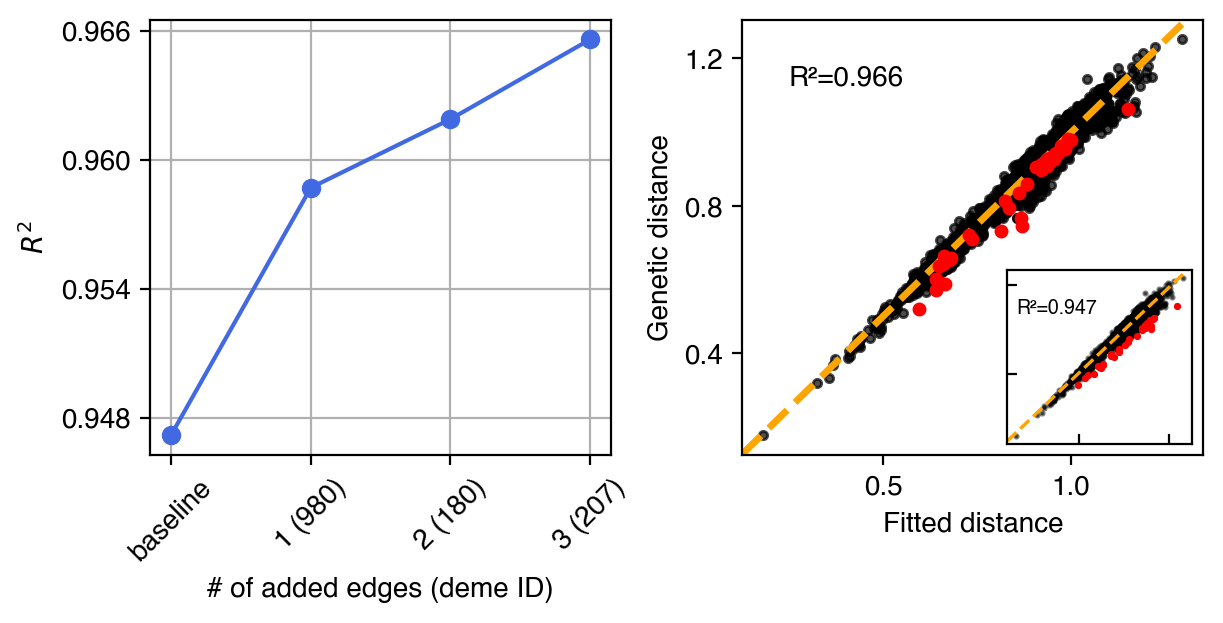

In [30]:
plot_FEEMSmix_summary(seq_results, sequential=True)

After fitting $K=3$ LREs we notice that there is an improvement in the model fit compared to no LREs (notice how the red points have moved closer to the regression line). For further interpretation and more functionality, see _further-exploration.iynb_ or _miscellaneous-functions.ipynb_.

Happy fitting!